# Plot predicted trajectories using saved models

In [ ]:
import os
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import torch

from imitation_cl.train.utils import check_cuda
from imitation_cl.model.hypernetwork import HyperNetwork, TargetNetwork, ChunkedHyperNetwork, str_to_ints, str_to_act
from imitation_cl.model.node import NODE
from imitation_cl.plot.trajectories import plot_ode_simple
from imitation_cl.logging.utils import read_dict, Dictobject
from tr_hn_node import eval_task as hn_eval_task
from tr_chn_node import eval_task as chn_eval_task

In [4]:
def predict_traj(model_dir, num_tasks, net_type='hn'):
    """Plot the predicted and ground truth trajectories for different tasks.
    Trained models saved on disk are used to produce the predictions.

    Args:
        model_dir (str): Directory where saved models are provided
        num_tasks (int): Total number of tasks for the corresponding dataset
        device (torch.device): 'cpu' or 'cuda'
        net_type (str, optional): Type of hypernetwork ('hn'|'chn'). Defaults to 'hn'.
    """

    assert net_type in ['hn','chn'], f'Unknown hypernetwork type {net_type}'

    cuda_available, device = check_cuda()

    commandline_args_path = os.path.join(model_dir, f'{net_type}_commandline_args.json')

    # ID of the last task (task_ids range from 0 to num_tasks-1)
    train_task_id = num_tasks - 1

    # Path of the saved model (model trained on the last task)
    model_path = os.path.join(model_dir, f'{net_type}_{train_task_id}.pth')

    # Use the same command line arguments that were used during training
    args = Dictobject(read_dict(commandline_args_path))

    # Shapes of the target network parameters
    target_shapes = TargetNetwork.weight_shapes(n_in=args.tnet_dim+args.explicit_time, 
                                                n_out=args.tnet_dim, 
                                                hidden_layers=str_to_ints(args.tnet_arch), 
                                                use_bias=True)

    # Create the hypernetwork
    hnet = None
    if net_type == 'hn':
        hnet = HyperNetwork(layers=str_to_ints(args.hnet_arch), 
                            te_dim=args.task_emb_dim, 
                            target_shapes=target_shapes,
                            device=device).to(device)
    elif net_type == 'chn':
        hnet = ChunkedHyperNetwork(final_target_shapes=target_shapes,
                                   layers=str_to_ints(args.hnet_arch),
                                   chunk_dim=args.chunk_dim,
                                   te_dim=args.task_emb_dim,
                                   ce_dim=args.chunk_emb_dim,
                                   device=device).to(device)    
            
    # Create a target network without parameters
    # Parameters are supplied during the forward pass of the hypernetwork
    tnet = TargetNetwork(n_in=args.tnet_dim+args.explicit_time, 
                         n_out=args.tnet_dim, 
                         hidden_layers=str_to_ints(args.tnet_arch),
                         activation_fn=str_to_act(args.tnet_act), 
                         use_bias=True, 
                         no_weights=True,
                         init_weights=None, 
                         dropout_rate=-1, 
                         use_batch_norm=False, 
                         bn_track_stats=False,
                         distill_bn_stats=False, 
                         out_fn=None,
                         device=device).to(device)

    # The NODE uses the target network as the RHS of its
    # differential equation
    # Apart from this, the NODE has no other trainable parameters
    node = NODE(tnet, explicit_time=args.explicit_time).to(device)

    # Load the hyper network for the last task_id
    if cuda_available:
        hnet = torch.load(model_path)
    else:
        hnet = torch.load(model_path, map_location=torch.device('cpu'))
        hnet.device = torch.device('cpu')

    # Show paramater size of hypernetwork
    network_type = 'HyperNetwork' if net_type == 'hn' else 'ChunkedHyperNetwork'
    print(f'Network type: {network_type}')
    param_size = 0
    for n, p in hnet.named_parameters():
        param_size += np.prod(list(p.shape))
    print(f'Parameter size: {param_size:,}')
    print(f'Size of model on disk: {os.path.getsize(model_path)/(1024*1024):.2f} MB')

    # Create a figure for plotting the predicted trajectories
    figw, figh = args.figw, args.figh
    plt.subplots_adjust(left=1/figw, right=1-1/figw, bottom=1/figh, top=1-1/figh)
    fig, axes = plt.subplots(figsize=(figw, figh), 
                                sharey=True, 
                                sharex=True,
                                ncols=num_tasks if num_tasks<=10 else (num_tasks//2), 
                                nrows=1 if num_tasks<=10 else 2,
                                subplot_kw={'aspect': 1})

    # Row column for plot with trajectories
    r, c = 0, 0

    # Evaluate on all the past and current task_ids
    for eval_task_id in trange(train_task_id+1):
        # Figure is plotted only for the last task
        
        eval_task = hn_eval_task if net_type == 'hn' else chn_eval_task
        eval_traj_metrics, eval_traj_metric_errors, plot_data = eval_task(args, eval_task_id, hnet, tnet, node, device)

        # Plot the trajectories predicted by the loaded model

        # Read the task names to use in the plot
        task_names_map = read_dict(args.task_names_path)

        r = 1 if num_tasks<=10 else eval_task_id//(num_tasks//2)
        c = eval_task_id if num_tasks<=10 else eval_task_id%(num_tasks//2)
        t, y_all, ode_rhs, y_hat = plot_data
        ax = axes[c] if num_tasks<=10 else axes[r][c]
        handles, labels = plot_ode_simple(t, y_all, ode_rhs, y_hat, ax=ax, explicit_time=args.explicit_time)
        name = list(task_names_map.values())[eval_task_id]
        ax.set_title(name, fontsize=args.plot_fs)
        
        # Remove axis labels and ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.xaxis.get_label().set_visible(False)
        ax.yaxis.get_label().set_visible(False)

        # Helloworld demos are recorded from the robot's perspective
        # Reflect the trajectories for better readability on the screen
        if 'helloworld' in model_dir:
            ax.invert_xaxis()
            ax.invert_yaxis()

        fig.legend(handles, labels, loc='lower center', fontsize=args.plot_fs, ncol=len(handles))

    fig.subplots_adjust(hspace=-0.2, wspace=0.1)

## LASA (with time input) - Hypernetwork

Network type: HyperNetwork
Parameter size: 4,319,658
Size of model on disk: 16.49 MB


100%|██████████| 26/26 [05:03<00:00, 11.67s/it]


<Figure size 432x288 with 0 Axes>

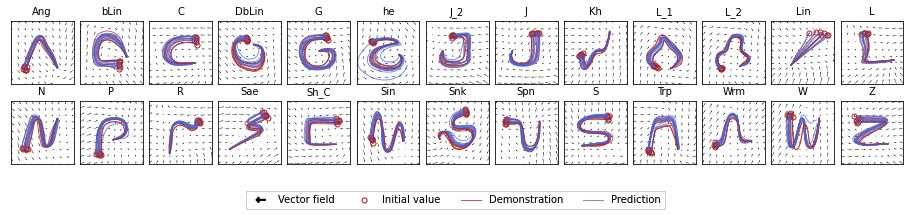

In [5]:
predict_traj(model_dir='trained_models/lasa/explicit_time', num_tasks=26, net_type='hn')

## LASA (with time input) - Chunked hypernetwork

In [ ]:
predict_traj(model_dir='trained_models/lasa/explicit_time', num_tasks=26, net_type='chn')

## LASA (without time input) - Hypernetwork

In [ ]:
predict_traj(model_dir='trained_models/lasa/no_time', num_tasks=26, net_type='hn')

## LASA (without time input) - Chunked hypernetwork

In [ ]:
predict_traj(model_dir='trained_models/lasa/no_time', num_tasks=26, net_type='chn')

## Helloworld (with time input) - Hypernetwork

In [ ]:
predict_traj(model_dir='trained_models/helloworld/explicit_time', num_tasks=7, net_type='hn')

## Helloworld (with time input) - Chunked hypernetwork

In [ ]:
predict_traj(model_dir='trained_models/helloworld/explicit_time', num_tasks=7, net_type='chn')

## Helloworld (without time input) - Hypernetwork

In [ ]:
predict_traj(model_dir='trained_models/helloworld/no_time', num_tasks=7, net_type='hn')

## Helloworld (without time input) - Chunked hypernetwork

In [ ]:
predict_traj(model_dir='trained_models/helloworld/no_time', num_tasks=7, net_type='chn')